In [5]:
# Data processing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import glob

import torch
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from PIL import Image, ImageEnhance

from sklearn.utils import shuffle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import os

# Print first 10 file names as a sample 
count = 0
max_files = 10  # Set the maximum number of files to print

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if count < max_files:
            print(os.path.join(dirname, filename))
            count += 1
        else:
            break

2024-02-19 20:48:17.462618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 20:48:17.462763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 20:48:17.616645: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_52.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_10.tif
/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8_mask.tif


In [7]:
class CFG:
    
    class path:
        to_root =  '../input/lgg-mri-segmentation/kaggle_3m/'
    
    class dataloader:
        batch_size = 64
    
    class model:
        lr = .001
        n_epochs = 50
        n_classes = 1
        seed = 42

        model_name = "unet"

        optimizer='Adam'
        criterion='BCELoss'

        path_save_model='model.pth',

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
def set_seed(seed=0):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed()

In [9]:
mask_files = glob.glob(f"{CFG.path.to_root}*/*_mask*")
diagnosis = [np.any(cv2.imread(file)) for file in tqdm(mask_files)]
image_files = [file.replace('_mask', '') for file in tqdm(mask_files)]

100%|██████████| 3929/3929 [00:00<00:00, 884421.21it/s]


In [21]:
import pandas as pd 
df = pd.DataFrame({
    "image_path": image_files,
    "mask_path": mask_files,
    "diagnosis": diagnosis
})

print(f"df.shape={df.shape}")
df.sample(3).T

df.shape=(3929, 3)


,3291,1004,1254
image_path,../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
mask_path,../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
diagnosis,False,False,True


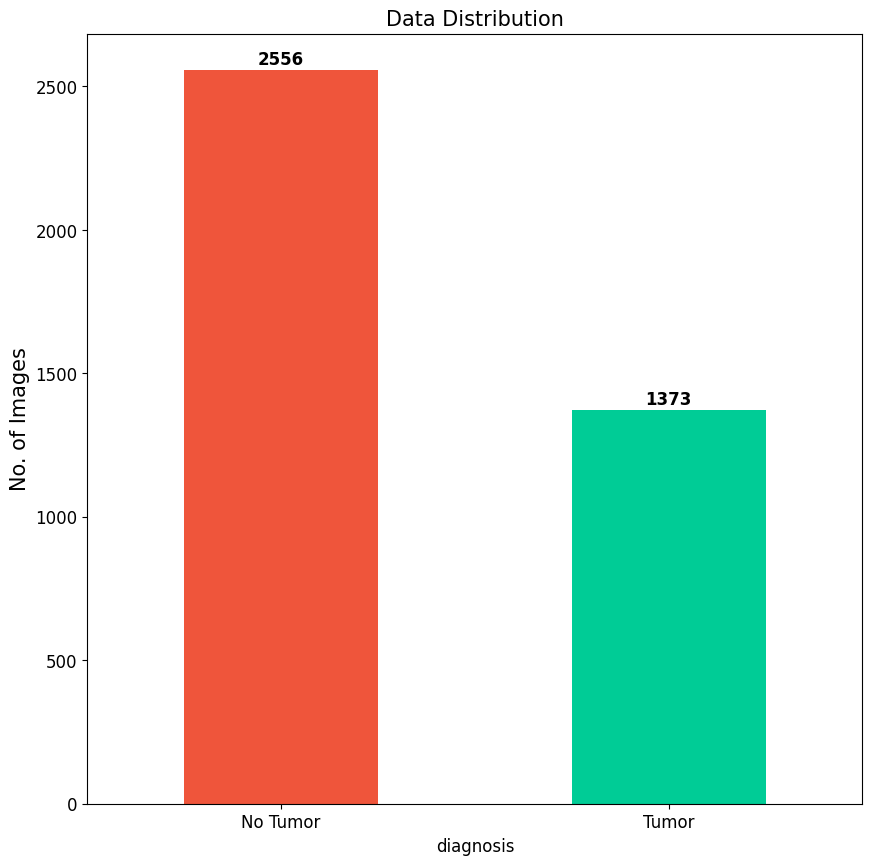

In [28]:
ax = df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10, 10), color=['#EF553B', '#00CC96'])
ax.set_ylabel('No. of Images', fontsize=15)
ax.set_title('Data Distribution', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)

for i, rows in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows + 20), ha='center', fontweight='bold', fontsize=12)

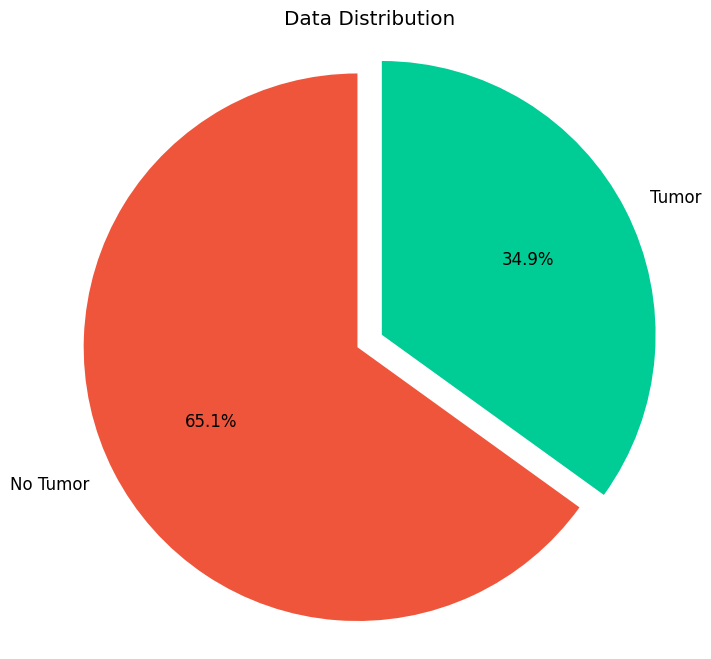

In [32]:
# Convert the bar chart data into a pie chart format
labels = ['No Tumor', 'Tumor']
sizes = df['diagnosis'].value_counts().values

# Define explode values to separate the slices
explode = (0.1, 0)

# Create a pie chart with separated slices
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=['No Tumor', 'Tumor'], autopct='%1.1f%%', startangle=90, colors=['#EF553B', '#00CC96'], explode=explode)

# Add title and labels
plt.title('Data Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Display the pie chart
plt.show()

In [34]:
train_df, val_df = train_test_split(df, stratify=df['diagnosis'], test_size=0.1, random_state=0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [35]:
print(f"Train : {train_df.shape} => {len(train_df) / len(df)}")
print(f"Validation : {val_df.shape} => {len(val_df) / len(df)}")
print(f"Test : {test_df.shape} => {len(test_df) / len(df)}")

Train : (3005, 3) => 0.7648256553830491
Validation : (393, 3) => 0.10002545176889793
Test : (531, 3) => 0.13514889284805293


In [36]:
images, masks = [], []
df_positive = train_df[train_df['diagnosis'] == 1].sample(5).values

for sample in df_positive:
    img = cv2.imread(sample[0])
    mask = cv2.imread(sample[1])
    images.append(img)
    masks.append(mask)
images = np.hstack(np.array(images))
masks = np.hstack(np.array(masks))

In [37]:
image_path, mask_path = train_df[train_df['diagnosis'] == 1].sample(1)[["image_path", "mask_path"]].values[0]

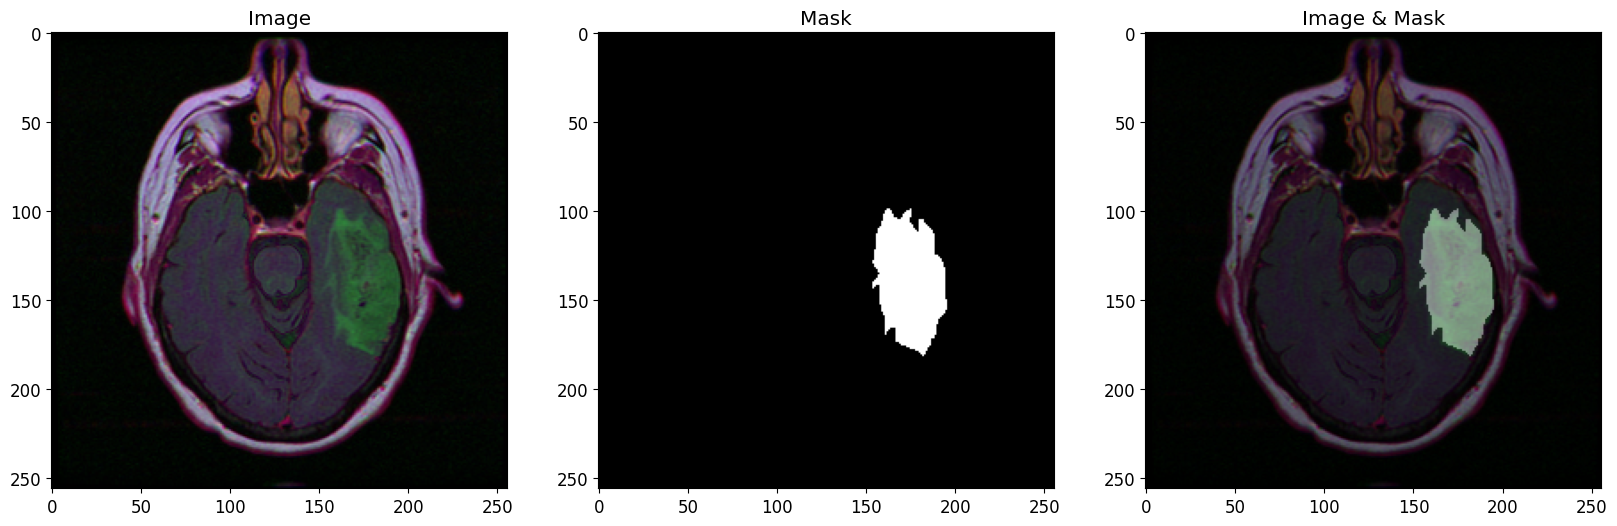

In [38]:
index_sample = 2
fig, axs = plt.subplots(1, 3, figsize=(20, 7))

image_sample = cv2.imread(image_path)
mask_sample = cv2.imread(mask_path)

axs[0].imshow(image_sample)
axs[0].set_title("Image")

axs[1].imshow(mask_sample)
axs[1].set_title("Mask")

axs[2].imshow(image_sample)
axs[2].imshow(mask_sample, alpha=.4)
axs[2].set_title("Image & Mask")

plt.show()

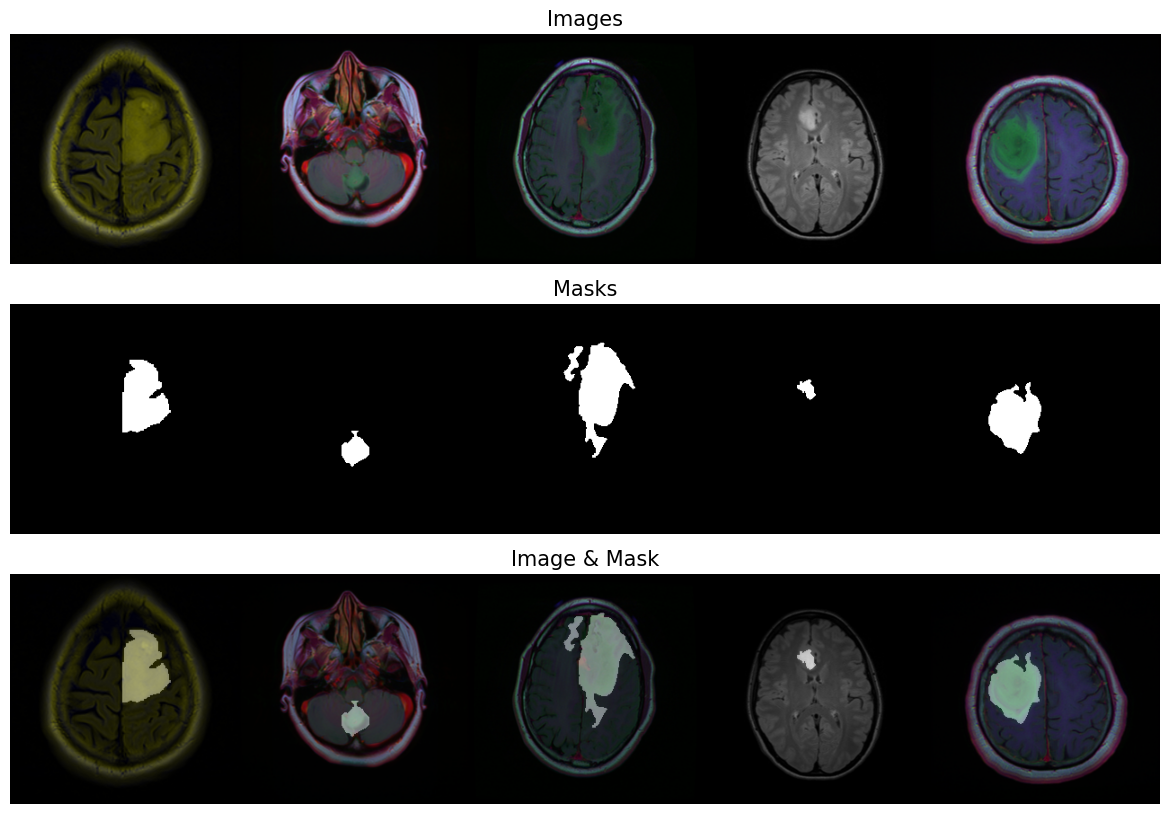

In [40]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(15,10))
grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.4)

grid[0].imshow(images)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')
grid[1].imshow(masks)

grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')

grid[2].imshow(images)
grid[2].imshow(masks, alpha=0.4)
grid[2].set_title('Image & Mask', fontsize=15)
grid[2].axis('off')
plt.show()

### Image Statistics

In [42]:
import pandas as pd
from PIL import Image
import os

# Function to calculate image statistics
def calculate_image_statistics(row):
    image_path = row['image_path']
    with Image.open(image_path) as img:
        width, height = img.size
        mean_intensity = float(img.convert('L').resize((1, 1)).getpixel((0, 0)))
        return pd.Series({
            'width': width,
            'height': height,
            'mean_intensity': mean_intensity
        })

# Assuming 'df' is the DataFrame containing image paths and diagnoses
# You can replace 'df' with your actual DataFrame name
image_statistics = df.apply(calculate_image_statistics, axis=1)

# Display image statistics
print("Image Statistics:")
print(image_statistics.describe())

Image Statistics:
        width  height  mean_intensity
count  3929.0  3929.0     3929.000000
mean    256.0   256.0       25.874014
std       0.0     0.0       10.603104
min     256.0   256.0        0.000000
25%     256.0   256.0       20.000000
50%     256.0   256.0       26.000000
75%     256.0   256.0       33.000000
max     256.0   256.0       64.000000


Understanding these characteristics is important for preprocessing and analysis tasks, such as normalization, filtering, or feature extraction, to ensure that the data is appropriately processed for machine learning models. 

- Width and Height: All images in the dataset have a width and height of 256 pixels. This suggests that the images are likely squared (256x256 pixels). 

- Mean Intensity: The mean intensity across all images is approximately 25.87. Intensity values typically range from 0 to 255 in grayscale images, so a mean intensity of 25.87 indicates that the images are relatively dark on average, with pixel values concentrated towards the lower end of the intensity scale. 

- Standard Deviation of Intensity: The standard deviation of intensity is 10.60, indicating the variability of pixel intensities within the images. A higher standard deviation suggests more variability in pixel intensities across the images. 

- Minimum and Maximum Intensity: The minimum intensity is 0, indicating that there are pixels with zero intensity (likely representing black areas). The maximum intensity is 64, suggesting that the images are not highly contrasted and do not contain very bright regions. 

- Percentiles: The percentiles provide information about the distribution of intensity values. For example, the 25th percentile (Q1) is 20, meaning that 25% of the images have a mean intensity of 20 or lower. The 50th percentile (median or Q2) is 26, indicating that 50% of the images have a mean intensity of 26 or lower. The 75th percentile (Q3) is 33, showing that 75% of the images have a mean intensity of 33 or lower. 

These statistics suggest that the images in the dataset are relatively uniform in size (256x256 pixels) and have a moderate range of pixel intensities, with most images being relatively dark.  

Based on the image statistics, several preprocessing and analysis suggestions can be made:

- Normalize Pixel Intensities: The mean intensity of approximately 25.87 suggests that the pixel intensities are relatively low. Normalizing the pixel values to a range of [0, 1] or [-1, 1] can help reduce the impact of intensity variations and improve model performance.

- Enhance Contrast: Adjusting the contrast based on mean intensity values can help improve the visibility of features, especially in images with lower intensities like glioma. This can be done using techniques such as histogram equalization or adaptive histogram equalization.

- Noise Reduction: The standard deviation of intensity of approximately 10.60 indicates a moderate variability in pixel intensities. Applying noise reduction techniques such as Gaussian blur or median filtering can help improve image quality and reduce the impact of outliers.

- Feature Extraction: Consider extracting meaningful features from the images, such as texture features or shape descriptors, to capture important characteristics for tumor classification. These features can then be used as input to machine learning models.

- Model Selection: Based on the characteristics of the dataset, consider using convolutional neural networks (CNNs) for image classification tasks. CNNs are well-suited for learning from image data and can automatically learn relevant features from the images.

By implementing these preprocessing and analysis suggestions, it is possible to enhance the quality of the dataset and improve the performance of machine learning models trained on the data.